In [24]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
from PIL import Image
from tqdm.notebook import tqdm
import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [13]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [14]:
EXP_NAME

'exp110'

## subの用意

In [15]:
sub1 = pd.read_csv('../exp086/exp086_cost_snap_sub.csv')
sub2 = pd.read_csv('../exp109/exp109_cost_snap_sub.csv')

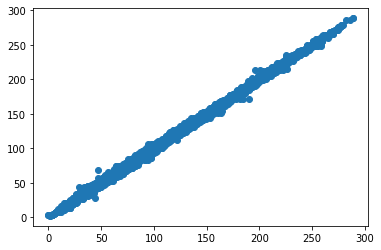

In [16]:
x = sub1['x']
y = sub1['y']
_x = sub2['x']
_y = sub2['y']
plt.scatter(x, _x)

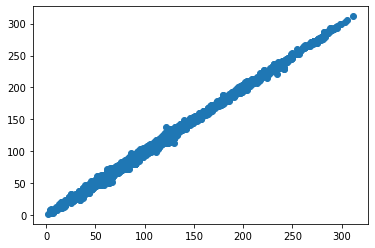

In [17]:
plt.scatter(y, _y)

In [18]:
sub = sub1.copy()
sub['x'] = sub1['x'] * 0.5 + sub2['x'] * 0.5
sub['y'] = sub1['y'] * 0.5 + sub2['y'] * 0.5
sub

site_path_timestamp  floor           x  \
0      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   93.728470   
1      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   79.662285   
2      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   84.025669   
3      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   83.033194   
4      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   81.657740   
...                                                  ...    ...         ...   
10128  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  205.596040   
10129  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  202.574510   
10130  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  201.819690   
10131  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  195.825880   
10132  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  192.553130   

                y  
0       97.948860  
1      102.766754  
2      105.113658  
3      109.573483  
4      110.509090  
...           ...  
10128   98.605774  
10129  101.132225  
10130  104.936270  
10131  109.711815  
10132  111.863014  

[10133 rows x 4 columns]

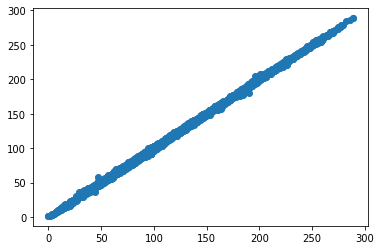

In [19]:
x_ = sub['x']
y_ = sub['y']
plt.scatter(x, x_)

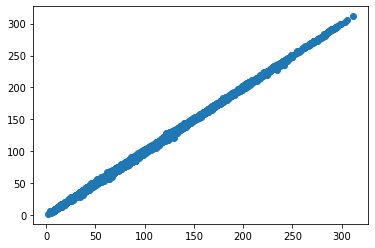

In [20]:
plt.scatter(y, y_)

## device id leak

In [21]:
# https://www.kaggle.com/iwatatakuya/use-leakage-considering-device-id-postprocess
def apply_device_leak(df_sub, root_dir):

    df_sub = df_sub.reset_index()
    df_sub['site_id'] = df_sub['site_path_timestamp'].str.split('_', expand=True)[0]
    df_sub['path_id'] = df_sub['site_path_timestamp'].str.split('_', expand=True)[1]
    df_sub['timestamp'] = df_sub['site_path_timestamp'].str.split('_', expand=True)[2]
    list_site = df_sub['site_id'].unique()

    # make train data for each site
    df_leak = pd.DataFrame()
    for site_id in tqdm(list_site):
        print(site_id)
        ## train
        list_train_files = glob.glob(str(root_dir / f"indoor-location-navigation/train/{site_id}/**/*.txt"), recursive = True)
        l_pid = []
        l_sts = []
        l_ets = []
        l_swpx = []
        l_swpy = []
        l_ewpx = []
        l_ewpy = []
        l_d = []
        for filename in list_train_files:
            path_id = filename.split("/")[-1].split('.')[0]
            # path_id = filename.split(".")[2].split("/")[6]
            try: df_all = read_data_file_for_leak(filename)
            except:continue
            
            # get start and end timestamp
            sts = df_all.starttime
            ets = df_all.endtime
            
            df_waypoint = pd.DataFrame(df_all.waypoint)
            df_waypoint.columns = ['timestamp', 'waypoint_x','waypoint_y']
            df_waypoint["timestamp"] = (df_waypoint["timestamp"]).astype(float)
            
            # search start and end waypoints of each path
            swpx = df_waypoint.query("timestamp == @df_waypoint.timestamp.min()")["waypoint_x"].iloc[0]
            swpy = df_waypoint.query("timestamp == @df_waypoint.timestamp.min()")["waypoint_y"].iloc[0]
            ewpx = df_waypoint.query("timestamp == @df_waypoint.timestamp.max()")["waypoint_x"].iloc[0]
            ewpy = df_waypoint.query("timestamp == @df_waypoint.timestamp.max()")["waypoint_y"].iloc[0]

            # search device id besed on magn bias
            d = sum(df_all.magn_uncali[0,4:7])
            if d == 0:d = sum(df_all.magn_uncali[0,1:4] - df_all.magn[0,1:4])
            d = round(d,2)

            l_pid += [path_id]
            l_sts += [sts]
            l_ets += [ets]
            l_swpx += [swpx]
            l_swpy += [swpy]
            l_ewpx += [ewpx]
            l_ewpy += [ewpy]
            l_d += [d]        
        df_mart_train = pd.DataFrame(data={"path_id": l_pid,
                                        "start_time": l_sts, "end_time": l_ets,
                                        "start_waypoint_x": l_swpx, "start_waypoint_y": l_swpy,
                                        "end_waypoint_x": l_ewpx, "end_waypoint_y": l_ewpy,
                                        "device": l_d},
                                    columns=["path_id","start_time","end_time","start_waypoint_x","start_waypoint_y",
                                            "end_waypoint_x", "end_waypoint_y", "device"])

        l_pid = []
        l_sts = []
        l_ets = []
        l_swpx = []
        l_swpy = []
        l_ewpx = []
        l_ewpy = []
        l_d = []
        
        ## test
        df_sample_site = df_sub.query("site_id == @site_id")
        df_sample_site.loc[:, "timestamp"] = df_sample_site["timestamp"].astype(float).values
        list_path = df_sample_site["path_id"].unique()
        for path_id in list_path:
            df_sample_path = df_sample_site.query("path_id == @path_id")
            filename = root_dir / f"indoor-location-navigation/test/{path_id}.txt"
            df_all = read_data_file_for_leak(filename)
            df_wifi = pd.DataFrame(df_all.wifi)
            df_wifi.columns = ['timestamp', 'ssid', 'bssid', 'rssi', 'last_seen_timestamp']
            df_wifi["timestamp"] = (df_wifi["timestamp"]).astype(float)
            df_wifi["last_seen_timestamp"] = (df_wifi["last_seen_timestamp"]).astype(float)  
            
            df_ibeacon = pd.DataFrame(df_all.ibeacon)
            # retrieve raw timestamp
            if len(df_ibeacon) > 0:
                df_ibeacon.columns = ['timestamp', 'uuid', 'rssi', 'dist','last_seen_timestamp']
                df_ibeacon["timestamp"] = (df_ibeacon["timestamp"]).astype(float)
                df_ibeacon["last_seen_timestamp"] = (df_ibeacon["last_seen_timestamp"]).astype(float)
                time_diff = df_ibeacon.loc[0,"last_seen_timestamp"]-df_ibeacon.loc[0,"timestamp"]
            else:
                time_diff = (df_wifi["last_seen_timestamp"] - df_wifi["timestamp"]).max()
                
            # search device id besed on magn bias
            d = sum(df_all.magn_uncali[0,4:7])
            if d == 0:d = sum(df_all.magn_uncali[0,1:4] - df_all.magn[0,1:4])
            d = round(d,2)
            
            sts = df_all.starttime + time_diff
            ets = df_all.endtime + time_diff
            swpx = np.nan;swpy = np.nan; ewpx = np.nan; ewpy = np.nan;floor = np.nan
            # x and y
            df_start = df_mart_train.query("device == @d and start_time > @ets - 2000 and start_time < @ets + 10000").sort_values("start_time").reset_index()
            df_end = df_mart_train.query("device == @d and end_time < @sts + 2000 and end_time > @sts - 10000").sort_values("end_time",ascending=False).reset_index()
            if len(df_start) > 0:
                ewpx = df_start.iloc[0]["start_waypoint_x"]
                ewpy = df_start.iloc[0]["start_waypoint_y"]
            if len(df_end) > 0:
                swpx = df_end.iloc[0]["end_waypoint_x"]
                swpy = df_end.iloc[0]["end_waypoint_y"]

            l_pid += [path_id]
            l_sts += [sts]
            l_ets += [ets]
            l_swpx += [swpx]
            l_swpy += [swpy]
            l_ewpx += [ewpx]
            l_ewpy += [ewpy]
            l_d += [d]    
        
        df_mart_test = pd.DataFrame(data={"path_id": l_pid,
                                        "start_time": df_all.starttime, "end_time": df_all.endtime,
                                        "start_waypoint_x": l_swpx, "start_waypoint_y": l_swpy,
                                        "end_waypoint_x": l_ewpx, "end_waypoint_y": l_ewpy,
                                        "device": l_d},
                                    columns=["path_id","start_time","end_time","start_waypoint_x","start_waypoint_y",
                                            "end_waypoint_x", "end_waypoint_y","device"])
        
        df_leak = df_leak.append(df_mart_test)
        
    replace_cnt = 0
    # apply leakage waypoint
    list_path = df_sub["path_id"].unique()
    for path_id in tqdm(list_path):
        df_sub_path = df_sub.query("path_id == @path_id")
        start_idx = df_sub.loc[df_sub["path_id"] == path_id].index.min()
        end_idx = df_sub.loc[df_sub["path_id"] == path_id].index.max()
        start_x = df_sub_path.at[start_idx,"x"]
        start_y = df_sub_path.at[start_idx,"y"]
        end_x = df_sub_path.at[end_idx,"x"]
        end_y = df_sub_path.at[end_idx,"y"]
        start_x_leak = df_leak.query("path_id == @path_id")["start_waypoint_x"].iloc[0]
        start_y_leak = df_leak.query("path_id == @path_id")["start_waypoint_y"].iloc[0]
        end_x_leak = df_leak.query("path_id == @path_id")["end_waypoint_x"].iloc[0]
        end_y_leak = df_leak.query("path_id == @path_id")["end_waypoint_y"].iloc[0]
        if not np.isnan(start_x_leak):
            df_sub.at[start_idx,"x"] = start_x_leak
            df_sub.at[start_idx,"y"] = start_y_leak
            replace_cnt += 1
        if not np.isnan(end_x_leak):
            df_sub.at[end_idx,"x"] = end_x_leak
            df_sub.at[end_idx,"y"] = end_y_leak
            replace_cnt += 1
    print(replace_cnt)
    return df_sub

In [27]:
import sys
sys.path.append('../../')
from src.io_f import read_data_file, read_data_file_for_leak
root_dir = Path('../../input/')

sub_copy = sub.copy()  # 後から比較できるよう
leak_sub = apply_device_leak(sub, root_dir)
leak_sub

  0%|          | 0/24 [00:00<?, ?it/s]

5a0546857ecc773753327266
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
5c3c44b80379370013e0fd2b
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
5d27075f03f801723c2e360f
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is tryi

  0%|          | 0/626 [00:00<?, ?it/s]

381


index                                site_path_timestamp  floor  \
0          0  5a0546857ecc773753327266_046cfa46be49fc1083481...      0   
1          1  5a0546857ecc773753327266_046cfa46be49fc1083481...      0   
2          2  5a0546857ecc773753327266_046cfa46be49fc1083481...      0   
3          3  5a0546857ecc773753327266_046cfa46be49fc1083481...      0   
4          4  5a0546857ecc773753327266_046cfa46be49fc1083481...      0   
...      ...                                                ...    ...   
10128  10128  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5   
10129  10129  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5   
10130  10130  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5   
10131  10131  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5   
10132  10132  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5   

                x           y                   site_id  \
0       93.728470   97.948860  5a0546857ecc773753327266   
1       79.662285  102.766754  5a0546857ecc773753327266   
2       84.025669  105.113658  5a0546857ecc773753327266   
3       83.033194  109.573483  5a0546857ecc773753327266   
4       81.657740  110.509090  5a0546857ecc773753327266   
...           ...         ...                       ...   
10128  205.596040   98.605774  5dc8cea7659e181adb076a3f   
10129  202.574510  101.132225  5dc8cea7659e181adb076a3f   
10130  201.819690  104.936270  5dc8cea7659e181adb076a3f   
10131  195.825880  109.711815  5dc8cea7659e181adb076a3f   
10132  192.553130  111.863014  5dc8cea7659e181adb076a3f   

                        path_id      timestamp  
0      046cfa46be49fc10834815c6  0000000000009  
1      046cfa46be49fc10834815c6  0000000009017  
2      046cfa46be49fc10834815c6  0000000015326  
3      046cfa46be49fc10834815c6  0000000018763  
4      046cfa46be49fc10834815c6  0000000022328  
...                         ...            ...  
10128  fd64de8c4a2fc5ebb0e9f412  0000000082589  
10129  fd64de8c4a2fc5ebb0e9f412  0000000085758  
10130  fd64de8c4a2fc5ebb0e9f412  0000000090895  
10131  fd64de8c4a2fc5ebb0e9f412  0000000096899  
10132  fd64de8c4a2fc5ebb0e9f412  0000000100447  

[10133 rows x 8 columns]

In [29]:
# leakのindex
# np.save(f'leak_id', leak_id)

In [ ]:
# # 時間短縮
# leak_sub = sub.copy()
# leak_id = np.load('../exp097/leak_id.npy')
# _leak_sub = pd.read_csv('../exp097/exp097_cost_snap_leak_sub.csv')
# leak_sub.loc[leak_id, 'x'] = _leak_sub.loc[leak_id, 'x']
# leak_sub.loc[leak_id, 'y'] = _leak_sub.loc[leak_id, 'y']
# leak_sub

In [30]:
# sub_copy: before / sub: after
print(((leak_sub['x'].to_numpy() - sub_copy['x'].to_numpy())!=0).sum())  # 変更されたデータ数
print(((leak_sub['y'].to_numpy() - sub_copy['y'].to_numpy())!=0).sum())  # 変更されたデータ数

309
305


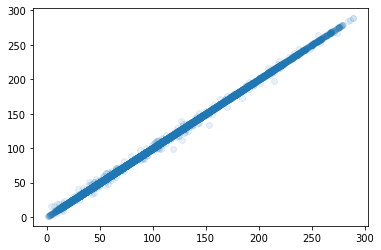

In [31]:
_x = sub_copy["x"]
_y = sub_copy["y"]
x = leak_sub["x"]
y = leak_sub["y"]
plt.scatter(x, _x, alpha=0.1)

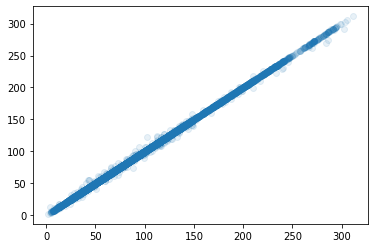

In [32]:
plt.scatter(y, _y, alpha=0.1)

In [33]:
leak_sub = leak_sub[['site_path_timestamp','floor','x','y']]
leak_sub

site_path_timestamp  floor           x  \
0      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   93.728470   
1      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   79.662285   
2      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   84.025669   
3      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   83.033194   
4      5a0546857ecc773753327266_046cfa46be49fc1083481...      0   81.657740   
...                                                  ...    ...         ...   
10128  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  205.596040   
10129  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  202.574510   
10130  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  201.819690   
10131  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  195.825880   
10132  5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...      5  192.553130   

                y  
0       97.948860  
1      102.766754  
2      105.113658  
3      109.573483  
4      110.509090  
...           ...  
10128   98.605774  
10129  101.132225  
10130  104.936270  
10131  109.711815  
10132  111.863014  

[10133 rows x 4 columns]

In [34]:
leak_sub.to_csv(EXP_NAME + '_cost_snap_leak_ensemble_sub.csv', index=False)